# Call Spectre.exe and Run loops

In [1]:
'''
Due to Subprocess ('proc.stdin.write') alway display something in the screen and 'communicate' function which does not 
display something but terminate the process every run
we turn to python module Winpexpect has functions giving no display but it is slower.

But if input all the 'start spectra', 'set parameters' and 'fit' commonds in a 'communicate', it work well.

For solving the hang problem of 'readline()': search this webpage Non blocking reading from a subprocess output stream in Python

Our demand: 
1, capture 'error' displayed or just copy 'RESULT.DAT'
2. in the loop, no display, no terminate
3. fast
'''

import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns # it will set to SNS style
sns.reset_orig() # set back to the Matplotlib style
sns.set() # set to sns style
# set the font
plt.rcParams["font.family"] = 'arial'
%matplotlib ipympl

import string

In [ ]:
## Ｃａｌｌ　Ｓｐｅｃｔｒｅ　ｖｉａ　ＣＭＤ．ｅｘｅ　：　works
import subprocess

proc = subprocess.Popen('cmd.exe', stdin = subprocess.PIPE, stdout = subprocess.PIPE, encoding='utf8')

proc.stdin.write('D:\n')
proc.stdin.write('cd D:\Other\Spectre2018\n')
proc.stdin.write('spectre.exe\n')
# here can insert cmd setting Bkq, ion type...
# netron
# neutron = ['\n']
# output = proc.communicate('\n')[0]
# mh calculation
mh = ['7', '2', '0,0,5','y','art2.txt'] # max feild [0,0,5]T, write to file name
output = proc.communicate('\n' + '\n'.join(mh) + '\n')[0]

# 'communicate' terminates the exe
print(output)
#proc.terminate()

## the old code also work which is input one by one
#proc.stdin.write('\n 7 \n 2\n 0,0,5 \n y \n art1.txt \n') # not working
# proc.stdin.write(' \n')
# proc.stdin.write('7 \n')
# proc.stdin.write('2 \n')
# proc.stdin.write('0,0,5 \n')
# proc.stdin.write('y \n')
# proc.stdin.write('art1.txt \n')
# output = proc.stdout.readline()
# print len(output)
# for idx in range(len(output)-4): # if range is larger than the output, it will wait for output
#     line = proc.stdout.readline()
#     if line != '':
#         print line.rstrip()
#         #data=myfile.read().replace
#     else:
#         break
#stdout, stderr = proc.communicate(' \n') # 'communicate' terminates the exe


In [ ]:
#  Ｄｅｆｉｎｉｎｇ　ａ　ｃｌａｓｓ　ｔｏ　ｒｕｎ　ｔｈｅ　ｅｘｅ　ｆｉｌｅ ａｎｄ　ｃａｌｃｕｌａｔｅｓ (not used)
import subprocess
import numpy as np
class cef_cal():
    ''' Set which ion manually in Spectre first!!!!
    console(set_pars): call Spectre via cmd, the set parameters set_pars: Bqk, B field; 
    cal_nd(set_pars,ndfpath): cal crystal field neutron scatering, and save to file;
    fit_nd(set_pars,cmds,ndfpath):input data, fit and save display to file by Python(Spectre also yields a file)
    cal_mh(set_pars,cmds):calcualted mh at a temperature, field direction and seve to file by Spectre
    '''
         
    def console(self,**kwarg):       
        proc = subprocess.Popen('cmd.exe', stdin = subprocess.PIPE, stdout = subprocess.PIPE)
        proc.stdin.write('D: \n')
        #proc.stdin.write('cd D:\9_Program files\crystal_field\Spectre \n')
        proc.stdin.write('cd D:\9_Program files\crystal_field \n')
        proc.stdin.write('spectre.exe \n')
        
        for par in set_pars:
            print('par', par)
            proc.stdin.write(par+'\n')
        proc.stdin.write('\n')
            
        setpars = proc.stdout.readline()
        print(len(setpars), setpars)
        for idx in range(len(setpars)-4): # if range is larger than the output, it will wait for output
            line = proc.stdout.readline()
            if line != '':
                print(line.rstrip())
            else:
                break 
        return(proc)          

    def cal_nd(self,set_pars,ndfpath):# set pars, cal, then write to a file by Python
        nd_output = self.console(set_pars).communicate('\n'+'1'+'\n')[0]
        #print nd_output
        with open(ndfpath,'a+') as f: # append or reading, if not exist then creat
            f.writelines(nd_output)
            f.close()
        return()
    def fit_nd(self,set_pars,cmds,ndfpath):
        nd_output = self.console(set_pars).communicate('\n'+'4'+'\n'+'\n'+'\n'.join(cmds)\
                                                       +'\n'+'\n'+'\n'+'y'+'\n')[0]
        # meaning of the cmds: \n enter main menu, 4\n select fit, \n not going to fit existing data, 
        # \n.join(cmds) input data, \n,\n input v return to E,C,R,V.. menu, \n fit,y\n save
        with open(ndfpath,'a+') as f: # append or read, if not exist then creat
            f.writelines(nd_output)
            f.close()
        return()
        
        
    def cal_mh(self,set_pars,cmds):# set pars and par for cal, then write to a file by Spectre
        mh_output = self.console(set_pars).communicate('\n'+'7'+'\n'+cmds[0]+'\n'+cmds[1]+'\n'\
                                                       +'y'+'\n'+cmds[2]+'\n')[0]
        # \n enter main menu,7\n selcte cal MH, 2\n 2K, 005\n field direction,y\n save, file,txt filename
        #print mh_output
        return()
    

## Define funs for fitting CEF and calculating MH, MT, Cp... 

In [8]:
# Ｄｅｆｉｎｅ　ｆｕｎｓ　ｎｏｔ　ｃｌａｓｓ　ｆｏｒ　ｃａｌ：　
# ｗｈｅｎ　ｕｓｉｎｇ，　ｆｉｒｓｔ　ｒｕｎ　ｃｏｎｓｏｌｅ　ｔｈｅｎ　ｒｕｎ　ｏｔｈｅｒｓ　ｗｉｔｈ　ｔａｋｉｎｇ　ｔｈｅ　ｐｒｏｃｅｓｓ　ａｓ　ｉｎｐｕｔ
# Note: 'stdin.write' seem not waiting for the finish of the run of evrey cmd

''' Set which ion manually in Spectre first!!!!
console(set_pars): call Spectre via cmd, the set parameters set_pars: Bqk, B field; 
cal_nd(set_pars,ndfpath): cal crystal field neutron scatering, and save to file;
fit_nd(set_pars,cmds,ndfpath):input data, fit and save display to file by Python(Spectre also yields a file)
cal_mh(set_pars,cmds):calcualted mh at a temperature, field direction and seve to file by Spectre
''' 
import subprocess
import os
def console(spectra_path= 'D:\6_Calculation_code\Spectre2018',**kwargs):
    set_pars = []
    if kwargs:
        for kw in kwargs:
            if kw=='set_pars': set_pars=kwargs[kw]
                
    #start Spectre
    proc = subprocess.Popen(['cmd.exe','-u','stdbuf'], bufsize=0, stdin = subprocess.PIPE, stdout = subprocess.PIPE,encoding='utf8')
    proc.stdin.write('D: \n')
    proc.stdin.write('cd ' + spectra_path + ' \n')
    proc.stdin.write('spectre.exe \n')
    #instea of above for calling Spectre, blow lines also works
#   proc.stdin.write('D: \n'+'cd D:\9_Program files\crystal_field \n'+'spectre.exe \n')
   
    if set_pars:
        for par in set_pars:
            #print 'par', par
            proc.stdin.write(par+'\n')
        proc.stdin.write('\n')          
#     if set_pars: # try 'write', but not work here in Spectre; 'write' not wait for running?
#         proc.stdin.write('\n'.join(set_pars))
#         proc.stdin.write('\n')
        
    #output = proc.stdout.readline()    
    #print 'length of output', len(output),'\n', output, '\n', 'Output ends'   
#     for idx in range(len(output)-4): # if range is larger than the output, it will wait for output
#         line = proc.stdout.readline()
#         if line != '':
#             print line.rstrip('\n')
#         else:
#             break 
    return(proc)

def start_setPar_fit(fitcmds, spectra_path= 'D:\6_Calculation_code\Spectre2018', **kwargs):
    set_pars = []
    save_path = []
    if kwargs:
        for kw in kwargs:
            if kw=='set_pars': set_pars=kwargs[kw]
            if kw=='save_path': save_path=kwargs[kw]    
    #start Spectr，set CEF parameters and do fitting
    proc = subprocess.Popen('cmd.exe', stdin = subprocess.PIPE, stdout = subprocess.PIPE)
    if set_pars:
        output = proc.communicate('D: \n'+'cd ' + spectra_path + '\n' + 'spectre.exe \n'+ \
                                  '\n'.join(set_pars)+'\n'+'\n'+ \
                                  '\n'+'4'+'\n'+'\n'+'\n'.join(fitcmds)+'\n'+'\n'+'\n'+'y'+'\n')[0]
    else:
        output = proc.communicate('D: \n'+'cd ' + spectra_path + '\n' +'spectre.exe \n'+ \
                                  '\n'+'4'+'\n'+'\n'+'\n'.join(cmds)+'\n'+'\n'+'\n'+'y'+'\n')[0]
    if save_path:    
        with open(save_path,'w+') as f:
            f.writelines(output)
            f.close()   
    return


def fit_cef(proc,cmds,fpath,fname):
    output = proc.communicate('\n'+'4'+'\n'+'\n'+'\n'.join(cmds)+'\n'+'\n'+'\n'+'y'+'\n')[0]
    #meaning of the cmds: \n enter main menu, 4\n select fit, \n not going to fit existing data, 
    #\n.join(cmds) input data, \n,\n input v return to E,C,R,V.. menu, \n fit,y \n save
    with open(os.path.join(fpath,fname),'w+') as f: # append or read, if not exist then creat
        f.writelines(output)
        f.close()     
    return

def fit_cef1(proc,cmds,fpath,fname):
# because 'communicate' kills the proc when finishing, so try 'write' but cannot get output (to see 'error' or not)
    proc.stdin.write('\n'+'4'+'\n'+'\n'+'\n'.join(cmds)+'\n'+'\n'+'\n'+'y'+'\n')
    proc.stdin.flush() 
    #proc.wait() #hangs and spectra above is also waiting
    #output = proc.stdout.readlines() #hangs
#     for out in proc.stdout: # this can disply part but also hangs
#         print outr.strip('\n').split()
#     for line in iter(proc.stdout.readline, b''):# this can disply all but also hangs, can not run the next fit
#         print line.strip('\n').split()
    #proc.stdout.close()
#     with open(os.path.join(fpath,fname),'w+') as f: 
#         f.write(output)
#         f.close() 
#     print repr(output)
#     #print 'length of output', len(output),output.rstrip()
#     with open(os.path.join(fpath,fname),'w+') as f: 
#         for line in output: 
#             #print line.rstrip()
#             f.write(line.rstrip())
#     f.close()        
    return

def fit_cef2(proc,cmds,fpath,fname):
# because 'communicate' kills the proc when finishing, 
# so try 'write' and use communicate to get the output but it terminates the proc (no benifit) 
    proc.stdin.write('\n'+'4'+'\n'+'\n'+'\n'.join(cmds)+'\n'+'\n'+'\n'+'y'+'\n')
    output = proc.communicate()[0]
    #print output
    # loop all line to search 'error', we can also regular expression matching (see Notebook winpexpect)
    if any("ERROR!" in line.rstrip('\n').split() for line in output.split('\n\n')):#'output' is a string with 
        # single letter column, so split it based on '\n\n' into a list
        print('error','bad fit')
    else:
        print('Success')  
    return     

def cal_mh(proc,cmds):# cmds: ['2', '0 0 5', 'fname.txt'] (temp, field,filename)
    mh_output = proc.communicate('\n'+'7'+'\n'+cmds[0]+'\n'+cmds[1]+'\n'+'y'+'\n'+cmds[2]+'\n')[0]
    #meaning:\n enter main menu,7\n selcte cal MH, 2\n 2K, 005\n field direction,y\n save, file,txt filename
    #print mh_output
    return

def cal_mh1(proc,temp,field,fpath):
    proc.stdin.write('\n')
    proc.stdin.write('7 \n')
    proc.stdin.write(str(temp))
    proc.stdin.write('\n')
    proc.stdin.write(field)
    proc.stdin.write('\n')
    proc.stdin.write('y \n')
    proc.stdin.write(fpath)
    proc.stdin.write('\n')
    proc.communicate()
    proc.terminate()
    #meaning: \n enter main menu,7\n selcte cal MH, 2\n 2K, 005\n field direction,y\n save, file,txt filename
    #print mh_output
    return

def cal_cp(proc,T_range_npts,fname, debug=False):# The last two input must be strings
    output = proc.communicate('\n'+ '5 \n' + T_range_npts+'\n' +'y \n' +fname+'\n')
    if debug:
        print(output)
    return

def cal_xt(proc,maxT,fname):# The last two input must be strings
    proc.communicate('\n'+ '6 \n' + maxT+'\n' +'y \n' +fname+'\n')
    return

# Ho2Ti2O7 Cp

In [9]:
ce_levels = np.array([0.000,18.552,20.028,20.028,23.907,23.907,25.493,53.057,53.057,63.182,63.512,65.047,65.047,69.815,69.815,73.605])
ce_levels*1.08

array([ 0.     , 20.03616, 21.63024, 21.63024, 25.81956, 25.81956,
       27.53244, 57.30156, 57.30156, 68.23656, 68.59296, 70.25076,
       70.25076, 75.4002 , 75.4002 , 79.4934 ])

In [10]:
HoTiO =  ['1,68',  '2,274', '3,86.8', '8,83.7', '12,-62.5', '15, 101.6']# Ho2Ti2O7 pars from J. Appl. Phys., Vol. 87, No. 9, 1 May 2000
proc = console(set_pars = HoTiO)
cal_cp(proc,'0.1 10 100','HoTiO_cp_lowT.txt', debug=True)

('Microsoft Windows [Version 10.0.19045.2604]\n(c) Microsoft Corporation. All rights reserved.\n\n(c:\\Users\\jhxup\\anaconda3) c:\\Users\\jhxup\\0_MyIpython\\Crystal_field>D: \n\n(c:\\Users\\jhxup\\anaconda3) D:\\>cd D:\x06_Calculation_code\\Spectre2018 \n\n(c:\\Users\\jhxup\\anaconda3) D:\\>spectre.exe \n\n(c:\\Users\\jhxup\\anaconda3) D:\\>1,68\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>2,274\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>3,86.8\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>8,83.7\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>12,-62.5\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>15, 101.6\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>\n(c:\\Users\\jhxup\\anaconda3) D:\\>\n(c:\\Users\\jhxup\\anaconda3) D:\\>5 \n\n(c:\\Users\\jhxup\\anaconda3) D:\\>0.1 10 100\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>y \n\n(c:\\Users\\jhxup\\anaconda3) D:\\>HoTiO_cp_lowT.txt\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>', None)


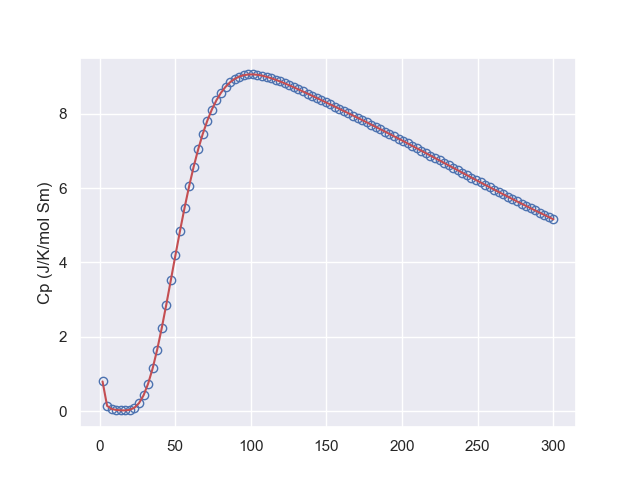

In [16]:
cp = np.genfromtxt(r'D:\Other\Spectre2018\HoTiO_cp.txt')
fig, ax =  plt.subplots()
ax.plot(cp[:,0],cp[:,1],'bo',mec='b',mew='1',mfc='none')
ax.plot(cp[:,0],cp[:,1],'r')
ax.set_ylabel(r'Cp (J/K/mol Sm)')
plt.show()

# Fitting the Sm2Zr2O7 neutron data

In [11]:
# fitting

# set initio pars
sm_pars =  ['1,42',  '2,320', '3,103', '8,85', '12,-70', '15,96']# Scaled Nd2Zr2O7 pars
#sm_pars =  ['1,90',  '2,320', '3,103', '8,85', '12,-70', '15,96']# modified Scaled Nd pars
sm_pars1 = ['1 28.5','2 370', '3 86',  '8 97', '12 -78', '15 123']# JPCM paper Sm2Ti2O7
#sm_pars1 = ['1 70',  '2 370', '3 86',  '8 97', '12 -78', '15 123']# Modified JPCM paper Sm2Ti2O7
sm_pars2 = ['1,47',  '2,294', '3,83',  '8,109','12,-62', '15,110']# Scaled Pr2Sn2O7 pars
sm_pars3 = ['1,28',  '2,289', '3,95',  '8,131','12,-64', '15,102']# Scaled Pr2Hf2O7 pars
nd_pars = ['1,53.9', '2,378', '3,118', '8,141', '12,-88', '15,157']
last = ['1,97', '2,412', '3,150',  '8,75','12,-100', '15,103']# Scaled Pr2Hf2O7 pars
proc = console(set_pars = last)
proc.communicate()


('Microsoft Windows [Version 10.0.19045.2604]\n(c) Microsoft Corporation. All rights reserved.\n\n(c:\\Users\\jhxup\\anaconda3) c:\\Users\\jhxup\\0_MyIpython\\Crystal_field>D: \n\n(c:\\Users\\jhxup\\anaconda3) D:\\>cd D:\x06_Calculation_code\\Spectre2018 \n\n(c:\\Users\\jhxup\\anaconda3) D:\\>spectre.exe \n\n(c:\\Users\\jhxup\\anaconda3) D:\\>1,97\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>2,412\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>3,150\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>8,75\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>12,-100\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>15,103\n\n(c:\\Users\\jhxup\\anaconda3) D:\\>\n(c:\\Users\\jhxup\\anaconda3) D:\\>',
 None)

In [ ]:
proc.communicate()
#proc.terminate()

In [ ]:
# fitting
# input data similar with the current calculation for checking the program (JPCM pars)
checkcmd=['e','1 2 0 0.1', '1 7 135 1','1 8 135 1', '1 9 146 1','1 10 146 1',
          '1 11 162 1','1 12 162 1', '1 13 176 1','1 14 176 1 \n',
          'c','1 7','1 8 \n', 'c','1 9','1 10 \n', 'c','1 11', '1 12 \n', 'c','1 13', '1 14 \n',
          'r', '6 1 7','6 1 13','0.64 0.1',
             '6 1 9','6 1 13','0.24 0.1',
             '6 1 11','6 1 13','0.51 0.1 \n',
          'v','1','2','3','8','12','15']

# fitting 20deg cut data
fitcmd=['e','1 2 0 0.1', '1 7 130 3','1 8 130 3', '1 9 161 5','1 10 161 5',
        '1 11 172 5','1 12 172 5', '1 13 185 5','1 14 185 5 \n',
       'c','1 7','1 8 \n', 'c','1 9','1 10 \n', 'c','1 11', '1 12 \n',
       'c','1 13', '1 14 \n',
        'r', '6 1 7','6 1 13','0.33 0.05',
             '6 1 9','6 1 13','0.26 0.08',
             '6 1 11','6 1 13','0.25 0.1 \n',
        'v','1','2','3','8','12','15']

# fitting 9deg cut data
# Nuetron data for inter-multiplet transitions
fitcmd0=['e','1 2 0 0.1', '1 7 130 3','1 8 130 3', '1 9 157 5','1 10 157 5',
        '1 11 168 5','1 12 168 5', '1 13 183 5','1 14 183 5 \n',
       'c','1 7','1 8 \n', 'c','1 9','1 10 \n', 'c','1 11', '1 12 \n',
       'c','1 13', '1 14 \n',
        'r', '6 1 7','6 1 13','0.37 0.05',
             '6 1 9','6 1 13','0.26 0.08',
             '6 1 11','6 1 13','0.38 0.08 \n',
        'v','1','2','3','8','12','15']
# Test exchanged energy of the two peak close to each other
fitcmd1=['e','1 2 0 0.1', '1 7 130 3','1 8 130 3', '1 9 168 5','1 10 168 5',
        '1 11 157 5','1 12 157 5', '1 13 183 5','1 14 183 5 \n',
       'c','1 7','1 8 \n', 'c','1 9','1 10 \n', 'c','1 11', '1 12 \n',
       'c','1 13', '1 14 \n',
        'r', '6 1 7','6 1 13','0.37 0.05',
             '6 1 9','6 1 13','0.38 0.08',
             '6 1 11','6 1 13','0.26 0.08 \n',
        'v','1','2','3','8','12','15']
# with assumed neutrond data for the intra-multiplet transtions below 35meV
fitcmd=['e','1 2 0 0.1',
        '1 3 16 3', '1 4 16 3', '1 5 26 5', '1 6 26 5',# the Raman data
        '1 7 130 3','1 8 130 3', '1 9 157 5','1 10 157 5',
        '1 11 168 5','1 12 168 5', '1 13 183 5','1 14 183 5 \n',
        'c','1 3','1 4 \n', 'c','1 5','1 6 \n',
        'c','1 7','1 8 \n', 'c','1 9','1 10 \n', 'c','1 11', '1 12 \n','c','1 13', '1 14 \n',      
        'r', '6 1 3','6 1 13','0.01 0.005',
             '6 1 5','6 1 13','0.01 0.005',
             '6 1 7','6 1 13','0.37 0.05',
             '6 1 9','6 1 13','0.26 0.08',
             '6 1 11','6 1 13','0.38 0.08 \n',
        'v','1','2','3','8','12','15']
# with assumed neutrond data for the intra-multiplet transtions below 35meV
fitcmd=['e','1 2 0 0.1',
        '1 3 12 0.1', '1 4 12 0.1', '1 5 34 0.1', '1 6 34 5',# maunal data
        '1 7 130 3','1 8 130 3', '1 9 157 5','1 10 157 5',
        '1 11 168 5','1 12 168 5', '1 13 183 5','1 14 183 5 \n',
        'c','1 3','1 4 \n', 'c','1 5','1 6 \n',
        'c','1 7','1 8 \n', 'c','1 9','1 10 \n', 'c','1 11', '1 12 \n','c','1 13', '1 14 \n',      
        'r', '6 1 3','6 1 13','0.01 0.01',
             '6 1 5','6 1 13','0.01 0.01',
             '6 1 7','6 1 13','0.37 0.08',
             '6 1 9','6 1 13','0.26 0.08',
             '6 1 11','6 1 13','0.38 0.08 \n',
        'v','1','2','3','8','12','15']

fitcmd=['e','1 2 0 0.1',
        '1 3 7.5 1', '1 4 7.5 1', '1 5 37 3', '1 6 37 3',# maunal data 
        '1 7 130 4','1 8 130 4', '1 9 157 5','1 10 157 5',
        '1 11 168 5','1 12 168 5', '1 13 183 5','1 14 183 5 \n',
        #'c','1 3','1 4 \n', 'c','1 5','1 6 \n',
        'c','1 7','1 8 \n', 'c','1 9','1 10 \n', 'c','1 11', '1 12 \n','c','1 13', '1 14 \n',      
        'r', #'6 1 3','6 1 13','0.01 0.01', # removed the intensity
             #'6 1 5','6 1 13','0.01 0.01',
             '6 1 7','6 1 13','0.37 0.1',
             '6 1 9','6 1 13','0.26 0.1',
             '6 1 11','6 1 13','0.38 0.1 \n',
        'v','1','2','3','8','12','15']


fpath = 'D:\9_Program files\crystal_field'
fname = 'szo_CEF_fit.txt' # file to store all the fitting output
proc = console()
#proc = console(set_pars = last)
fit_cef(proc,fitcmd,fpath,fname)
#proc.communicate()     

# Test the function: start Spectre, set parameter, fit and export the output to file
#start_setPar_fit(fitcmd, set_pars=last,save_path=r'D:\9_Program files\crystal_field\szo_CEF_fit.txt')



In [ ]:
# calcualted x-t and Cp
# first delet the files
try:
    os.remove(r'D:\9_Program files\crystal_field\szo_cp.txt')
    os.remove(r'D:\9_Program files\crystal_field\szo_xt.txt')
    os.remove(r'D:\9_Program files\crystal_field\szo_mh.txt')
except:
    pass
proc = console()
cal_cp(proc,'2 300 100','szo_cp.txt')
proc = console()
cal_xt(proc,'350','szo_xt.txt')
proc = console()
cal_mh(proc,['2','0 0 14','szo_mh.txt')

In [ ]:
# read and plot the Cp and XT data
rule = string.maketrans('D', 'E') # make a translation table (rules) for translating a string (D to E in the numbers)  
def load_xt(fname):    
    temp = np.genfromtxt(fname, usecols=(0,1,2,3), \
                         converters = {1: lambda val: float(val.translate(rule)),
                                       2: lambda val: float(val.translate(rule)),
                                       3: lambda val: float(val.translate(rule))}) 
    return temp

# load data
fnames = [r'D:\9_Program files\crystal_field\szo_cp.txt',
          r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\szo_cp_diditalized.txt',
          r'D:\9_Program files\crystal_field\szo_xt.txt',
          r'D:\3_Physical Properties\Nd2Zr2O7\Crystal\szo_pow_xt_080114.txt',
          r'D:\9_Program files\crystal_field\szo_xt_0cef_par_0-1000K.txt',
          r'D:\9_Program files\crystal_field\szo_xt_0cef_par_0-2000K.txt'] # this file is calculatd with zero CEF pars
szocp = np.genfromtxt(fnames[0]) # calculated
szocp1 = np.genfromtxt(fnames[1]) # data
szoxt = load_xt(fnames[2]) # calulated
szoxt1 = np.genfromtxt(fnames[3]) # data

In [ ]:
# Ｓｏｍｅｔｈｉｎｇ　ｅｌｓｅ：　Ｐｌｏｔ　ｔｈｅ　ｃａｌｃｕｌａｔｅｄ　ｆｒｅｅ　Ｓｍ＾３＋　ｉｏｎ　ｓｕｓｃｅｐｔｉｂｉｌｉｔｙ
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12,4))
# plot x-T
test = load_xt(fnames[4]) # calulated with zero CEF pars
mueff = 2.827*(test[:,0]*test[:,3])**0.5
axs[0].plot(test[:,0],mueff,'o')
test = load_xt(fnames[5]) # calulated with zero CEF pars
mueff = 2.827*(test[:,0]*test[:,3])**0.5
axs[1].plot(test[:,0],mueff,'o')
plt.show()

In [ ]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12,4))

# plot Cp
axs[0].plot(szocp1[:,0],szocp1[:,1],'bo',mec='b',mew='1',mfc='none')
axs[0].plot(szocp[:,0],szocp[:,1],'r')
axs[0].set_ylabel(r'Cp (J/K/mol Sm)')
# plot x-T
skipPts = 15
axs[1].plot(szoxt1[::skipPts,0],szoxt1[::skipPts,1]/2,'o',mec='b',mew='1',mfc='none',label=r'Measured')
#axs[1].plot(szoxt[:,0],szoxt[:,1],label=r'$\chi_{\rm z}$')
#axs[1].plot(szoxt[:,0],szoxt[:,2],label=r'$\chi_{\rm xy}$')
axs[1].plot(szoxt[:,0],szoxt[:,3],label=r'$\chi_{\rm powder}$')
axs[1].set_ylabel(r'$\chi$(emu/mol Sm)')
# plot 1/x-T
axs11 = axs[1].twinx()
axs11.grid(b=False)
axs11.plot(szoxt1[::skipPts,0],1./szoxt1[::skipPts,1]*2,'o',mec='b',mew='1',mfc='none', label='Measured')
axs11.plot(szoxt[:,0],1./szoxt[:,3],color='r', label='Calculated')
# Make the y-axis label and tick labels match the line color.
for tl in axs11.get_yticklabels():
    tl.set_color('black')
axs11.set_ylabel(r'$1/\chi_{\rm powder}$',color='black')

axs[0].legend(fontsize=14)
axs[1].legend(fontsize=14,loc='best')
axs11.legend(fontsize=14,loc='best')
plt.show()

In [ ]:
# Try subtracting the diamagnetic part
sns.set(color_codes=True)
skipPts = 15
def pltDiaMag(x1=0.0):
    global fig, ax, ax1
    ax.cla()  
    # plot x-T
    ax.plot(szoxt1[::skipPts,0],szoxt1[::skipPts,1]/2+x1,'o',mec='b',mew='1',mfc='none',label=r'Measured')
    ax.plot(szoxt[:,0],szoxt[:,3],color='r', label='Calculated')
    ax.set_ylabel(r'$\chi$(emu/mol Sm)')
    # plot 1/x-T
    ax1.cla()
    ax1.grid(b=False)
    ax1.plot(szoxt1[::skipPts,0],1./(szoxt1[::skipPts,1]+x1)*2,'o',mec='b',mew='1',mfc='none', label='Measured')
    ax1.plot(szoxt[:,0],1./szoxt[:,3],color='r', label='Calculated')
    ax1.set_ylabel(r'$1/\chi$(emu/mol Sm)')
    ax1.legend(loc='best')
    
    plt.suptitle(r'$\chi(T)$ of Sm$_2$Zr$_2$O$_7$ with diamganetic correction',fontsize=1)
    return fig

fig, ax = plt.subplots(figsize=(5,4))
ax1 = ax.twinx()

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

interact(pltDiaMag, x1=widgets.FloatSlider(min=0,max=0.0005,step=0.00001,value=0.000))

In [ ]:
# Ｔｒｙ　Ｒａｎｄｏｍ unfinished work!!!
storage = []
idxs = ['1','2','3','8','12','15']
iters=0

while iters<2:
    # start spectre
    proc = console()
    # set initio parameters (plus randoms)
    randoms = np.random.rand(6)*100
    cefp = map(str, np.array([42,320,103,85,-70,96])+randoms)

    for idx, par in zip(idxs,cefp):
        proc.stdin.write(idx+par+'\n')
        print idx, par
    proc.stdin.write('\n') 
    # fitting
    proc.stdin.write('\n'+'4'+'\n'+'\n'+'\n'.join(cmds)+'\n'+'\n'+'\n'+'n'+'\n')# do not write to file
    output = proc.communicate()[0]
    # store key factors
    if any("ERROR!" in line.rstrip('\n').split() for line in output.split('\n\n')):
        print cefp.extend(['error','\n'])
        storage.append(cefp.extend(['error','\n']))
    else:
        print cefp.extend(['Success','\n'])
        storage.append(cefp.extend(['Success','\n']))
    
    # start spectre
    proc = console()    
    # set initio parameters (minus randoms)
    randoms = np.random.rand(6)*100
    cefp = map(str, np.array([42,320,103,85,-70,96])-randoms)
    for idx, par in zip(idxs,cefp):
        proc.stdin.write(idx+par+'\n')
    proc.stdin.write('\n') 
    # fitting
    proc.stdin.write('\n'+'4'+'\n'+'\n'+'\n'.join(cmds)+'\n'+'\n'+'\n'+'n'+'\n')# do not write to file
    output = proc.communicate()[0]
    # store key factors
    if any("ERROR!" in line.rstrip('\n').split() for line in output.split('\n\n')):
        storage.append(cefp.extend(['error','\n']))
    else:
        storage.append(cefp.extend(['Success','\n']))
        
    iters = iters+1 
print storage    

## Calculating MH of crystal Pr2Hf2O7 and MT 

In [ ]:
# first start the process then trun and only after run a communicate or Stop kernal, can the proc stop
# the order refer to the paremeter order in Spectre software
nd_pars = ['1,48','2,412.1','3,147.1','8,110.0','12,-100','15,137'] #Nd2Zr2O7
prhfo = ['1,33.8','2,426','3,165.3','8,192.7','12,-112','15,178'] # pr2hf2o7
prsno = ['1,58','2,433','3,144.5','8,161','12,-107.5','15,192.3']# pr2sn2o7
print prsno
proc = console(set_pars = prhfo)
proc.communicate()
# proc.kill() why it is not working

In [ ]:
# loop to cal MH for field along z, y, x 0-5T at 0-350K
# after finish it will save files

#for temp in range(0,350,5):
    #print temp, 'pr_mh_at{}K.txt'.format(temp)
    cal_mh1(proc,temp,'5,0,0','pr_mhx_at{}K.txt'.format(temp))
    cal_mh1(proc,temp,'0,5,0','pr_mhy_at{}K.txt'.format(temp))
    cal_mh1(proc,temp,'0,0,5','pr_mhz_at{}K.txt'.format(temp))
    if temp==350-5:
        proc.communicate()

In [ ]:
# Ｃａｌｃｕｌａｔｅ　ｔｈｅ　ｆｉｅｌｄ　ｄｉｒｅｔｉｏｎ　ｉｎ　ｌｏｃａｌ　ｆｒａｍｅｓ
import numpy as np
# the matrixes transforming the mag field to the 4 local frames on a tetrahedra 
#(from Owen's Paper'A general theory of anisotropic... ')
r1 = np.array([[-2,1,1]/np.sqrt(6.),[0,-1,1]/np.sqrt(2.),[1,1,1]/np.sqrt(3.)])
r2 = np.array([[-2,-1,-1]/np.sqrt(6.),[0,1,-1]/np.sqrt(2.),[1,-1,-1]/np.sqrt(3.)])
r3 = np.array([[2,1,-1]/np.sqrt(6.),[0,-1,-1]/np.sqrt(2.),[-1,1,-1]/np.sqrt(3.)])
r4 = np.array([[2,-1,1]/np.sqrt(6.),[0,1,1]/np.sqrt(2.),[-1,-1,1]/np.sqrt(3.)])

Hdirections = np.array([[1,0,0]/np.sqrt(1.)*14.,[1,1,0]/np.sqrt(2.)*14,[1,1,1]/np.sqrt(3.)*14.])

Hdirections = np.array([[1,0,0]/np.sqrt(1.),[0,1,1]/np.sqrt(2.),[1,1,1]/np.sqrt(3.)])
#Hdirections = np.array([[1,0,0]/1.*14.,[1,1,0]/np.sqrt(2.)*14,[1,1,1]/np.sqrt(3.)]) # duplicating not multiplying

#print Hdirections
for idx, H in enumerate(Hdirections):
    h1, h2, h3, h4 = np.dot(r1,H), np.dot(r2,H),\
                     np.dot(r3,H), np.dot(r4,H)
    print  h1*14, h2, h3, h4, '\n'

In [ ]:
# ＭＨ：　ｆｉｅｌｄ　ａｌｏｎｇ　１１１，　ｏｎｌｙ　ｔｗｏ　ｔｙｐｅｓ　ｏｆ　ａｔｏｍｓ
fname = 'pr111mh{}T{}K.txt'.format(14,2)
fname = 'pr1'
proc = console()
cal_mh1(proc,2,'0,0,14',fname) # 0-14T [111]field along the local z of this atom

fname = 'pr111mh1{}T{}K.txt'.format(14,2)
fname = 'pr2'
proc = console()
cal_mh1(proc,2,'13.2,0,4.67',fname) # 0-14T [111] field along in the xz plane froming 19.47deg angle with x

# fname = 'pr111_atom2_mh{}T_at{}K.txt'.format(14,2)
# proc = console()
# cal_mh1(proc,2,'6.6, -11.4309,  -4.67',fname)

In [ ]:
# project the induced moment to the field direciton
## load the data of Spectre
import string
# the file names were changed and different from above ones
fpath = [r'D:\9_Program files\crystal_field\pr111mh14T2K_atom1.txt',
         r'D:\9_Program files\crystal_field\pr111mh14T2K_atom2.txt']
H_unit = [[0,0,1],[0.94280904, 0., 0.33333333]] # the unit vector of the fields of the two types atom 
natoms = [1,3]

dat = np.zeros((21,2)) # to store the MH for crystal

rule = string.maketrans('D', 'E') # make a translation table (rules) for translating a string (D to E in the numbers)
for hu, f, at in zip(H_unit,fpath,natoms):
    print hu,f, at
    temp = np.genfromtxt(f, usecols=(0,1,2,3), \
                         converters = {1: lambda val: float(val.translate(rule)),
                                       2: lambda val: float(val.translate(rule)),
                                       3: lambda val: float(val.translate(rule))}) 
    dat[:,1] = dat[:,1] + np.dot(temp[:,1:],hu)*at
    
dat[:,0] = temp[:,0]  
dat[:,1] = dat[:,1]/4.
dat111 = dat
print dat111

In [ ]:
# ＭＨ：　ｆｉｅｌｄ　ａｌｏｎｇ　１１０，　ｏｎｌｙ　ｔｗｏ　ｔｙｐｅｓ　ｏｆ　ａｔｏｍｓ
fname = 'pr110mh{}T{}K_atom{}.txt'.format(14,2,1)
proc = console()
cal_mh1(proc,2,'0,14,0',fname) # 0-14T [110]field along the local y of this atom

fname = 'pr110mh{}T{}K_atom{}.txt'.format(14,2,2)
proc = console()
cal_mh1(proc,2,'8.08290377, 0, 11.43095213',fname) # 0-14T [110] field along in the xz plane froming 35deg angle with z

In [ ]:
# project the induced moment to the field direciton
## load the data of Spectre
import string
# the file names were changed and different from above ones
fpath = [r'D:\9_Program files\crystal_field\pr110mh14T2K_atom1.txt',
         r'D:\9_Program files\crystal_field\pr110mh14T2K_atom2.txt']
H_unit = [[0,1,0],[0.57735027,0.,0.81649658]] # the unit vector of the fields of the two types atom 
natoms = [2,2]

dat = np.zeros((21,2)) # to store the MH for crystal

rule = string.maketrans('D', 'E') # make a translation table (rules) for translating a string (D to E in the numbers)
for hu, f, at in zip(H_unit,fpath,natoms):
    print hu,f, at
    temp = np.genfromtxt(f, usecols=(0,1,2,3), \
                         converters = {1: lambda val: float(val.translate(rule)),
                                       2: lambda val: float(val.translate(rule)),
                                       3: lambda val: float(val.translate(rule))}) 
    dat[:,1] = dat[:,1] + np.dot(temp[:,1:],hu)*at
    
dat[:,0] = temp[:,0]  
dat[:,1] = dat[:,1]/4.
dat110 = dat
print dat110

In [ ]:
# ＭＨ：　ｆｉｅｌｄ　ａｌｏｎｇ　１0０，　ｏｎｌｙ　ｏｎｅ　ｔｙｐｅ　ｏｆ　ａｔｏｍｓ
fname = 'pr100mh{}T{}K_atom{}.txt'.format(14,2,1)
proc = console()
cal_mh1(proc,2,'11.43095213,0.,8.08290377',fname) # 0-14T [100]field is in the xz plane forming 35deg angle with x

In [ ]:
# project the induced moment to the field direciton
## load the data of Spectre
import string
# the file names were changed and different from above ones

H_unit = [[0.81649658,0.,0.57735027]] # the unit vector of the fields of the two types atom 
natoms = [4]

dat = np.zeros((21,2)) # to store the MH for crystal
rule = string.maketrans('D', 'E') # make a translation table (rules) for translating a string (D to E in the numbers)
for hu, f, at in zip(H_unit,fpath,natoms):
    print hu,f, at
    temp = np.genfromtxt(f, usecols=(0,1,2,3), \
                         converters = {1: lambda val: float(val.translate(rule)),
                                       2: lambda val: float(val.translate(rule)),
                                       3: lambda val: float(val.translate(rule))}) 
    dat[:,1] = dat[:,1] + np.dot(temp[:,1:],hu)*at
    
dat[:,0] = temp[:,0]  
dat[:,1] = dat[:,1]/4.
dat100 = dat
print dat100

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (5,4))
ax.plot(dat111[:,0],dat111[:,1],label = '111')
ax.plot(dat110[:,0],dat110[:,1],label = '110')
ax.plot(dat100[:,0],dat100[:,1],label = '100')
ax.minorticks_on()

plt.xlabel(r"H (T)",size=14)
plt.ylabel(r'M ($\mu_B/at$)',size=14)
plt.legend(loc = 'best')
fig.show()

In [ ]:
# write data to file
fpath = r'D:\9_Program files\crystal_field\prhfo_crystal_MH.txt'
f = open(fpath,'w+')
np.savetxt(f, np.vstack([dat111.T, dat110[:,1],dat100[:,1]]).T )
f.close()
# print dat111.shape,dat110.shape, dat100.shape
# print np.vstack([dat111.T, dat110[:,1],dat100[:,1]]).T


In [ ]:
#　Ｐｒｏｄｕｃｅ　ＭＨ　ａｌｏｎｇ　ｌｏｃａｌ　ｘ，ｙ，ｚ　ａｎｄ　１１１　ｄｉｒｅｃｉｔｏｎｓ
fname = 'pr_xyz111.txt'#.format(14,2)
proc = console()
cal_mh1(proc,2,'8.0622577482985491 8.0622577482985491 8.0622577482985491',fname)

fname = 'pr_z.txt'#.format(14,2)
proc = console()
cal_mh1(proc,2,'0 0 14',fname)

fname = 'pr_y.txt'#.format(14,2)
proc = console()
cal_mh1(proc,2,'0 14 0',fname)

fname = 'pr_x.txt'#.format(14,2)
proc = console()
cal_mh1(proc,2,'14 0 0',fname)

In [ ]:
# Ｒｅａｄ ａｎｄ　Ｐｌｏｔ　ｔｈｅ　Ｓｍ２Ｚｒ２Ｏ７　Ｃｈｉ－Ｔ　ｄａｔａ
## load the data of Spectre
import string
import numpy as np
# the file names were changed and different from above ones
fpath = r'D:\9_Program files\crystal_field\Spectre\Sm2Zr2O7\sm_chi_T.dat'


rule = string.maketrans('D', 'E') # make a translation table (rules) for translating a string (D to E in the numbers)

dat = np.genfromtxt(fpath, usecols=(0,1,2,3),skip_header=1, \
                     converters = {1: lambda val: float(val.translate(rule)),
                                   2: lambda val: float(val.translate(rule)),
                                   3: lambda val: float(val.translate(rule))}) 


In [ ]:
# Ｐｌｏｔ
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots(figsize = (5,4))
ax1.plot(dat[:,0],dat[:,1],label = r'$\chi_Z$')
ax1.plot(dat[:,0],dat[:,2],label = r'$(\chi_X+\chi_Y)/2$')
ax1.plot(dat[:,0],dat[:,3],label = 'Powder')

#ax1.tick_params(axis='both',which='both',width=1,length=4,labelsize=12)

ax1.set_xlabel(r"T (K)",size=14)
ax1.set_ylabel(r'$\chi\ \rm (cm^3/mol$)',size=14)
ax1.legend(loc = 'best',frameon=False,fontsize=15)

ax2 = ax1.twinx()
ax2.plot(dat[:,0],1./dat[:,3],label=r'$1/\chi$', color='r')
ax2.set_ylabel( r'$1/\chi$', color='r',size=14)
for tl in ax2.get_yticklabels():
    tl.set_color('r')

#ax2.tick_params(axis='both',which='both',width=1,length=4,labelsize=12) 
#ax2.legend(loc = 'best',frameon=False,fontsize=15)

#plt.minorticks_on() # only set for the last plot
ax1.minorticks_on()
ax2.minorticks_on()


ax1.text(150,0.0025,'$\chi$ of single Sm$^{3+}$ \n cal. by SPECTRE',size=16, ha='left', va='center', 
         backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))#zorder=1 above axis
        

fig.show()
#fig.savefig(r'D:\9_Program files\crystal_field\Spectre\Sm2Zr2O7\sm_chi_T.jpg',bbox_inches="tight",verbose=True)

# Learning

In [ ]:
# call the software directly: but Ｎｏｔ　Ｗｏｒｋｉｎｇ
import subprocess
import os
app = r"D:\9_Program files\crystal_field/spectre.exe"
proc = subprocess.Popen(app, stdin=subprocess.PIPE,
                        stdout=subprocess.PIPE,stderr=subprocess.PIPE)
#subprocess.check_call([app, "-l"])

commands = ['7', '2', '0,0,5','y','art2.txt']
output = proc.communicate('\n' + '\n'.join(commands) + '\n')[0]
# 'communicate' terminates the exe
print output

In [ ]:
# call the software directly and print something: but Ｎｏｔ　ｗｏｒｋｉｎｇ
app = r"D:\9_Program files\crystal_field/spectre.exe"
proc = subprocess.Popen(app, stdin=subprocess.PIPE,
                        stdout=subprocess.PIPE,stderr=subprocess.PIPE)

proc.stdin.write(' \n')
output = proc.stdout.readline()
print len(output)
for idx in range(len(output)-4):
    line = proc.stdout.readline()
    if line != '':
        print line.rstrip()
        #data=myfile.read().replace
    else:
        break
        
proc.stdin.write('7 \n')
proc.stdin.write('2 \n')
proc.stdin.write('0,0,5 \n')
proc.stdin.write('y \n')
proc.stdin.write('art2.txt \n')

stdout, stderr = proc.communicate('\n') # at last terminate the exe
stdout

In [ ]:
## 　Ｗｒｉｔｔｉｎｇ　ａｌｌ　ｔｈｅ　ｄｉｐｌａｙ　ｔｏ　ａ　ｆｉｌｅ　ｎｏｔ　ｔｈｅ　ｏｕｔｐｕｔ　ｆｉｌｅ　ｓｔｏｒｉｎｇ　ｔｈｅ　ｄａｔａ　
# Create a file object to store the output in a folder first. 
# getting the file we are connected to
import subprocess

outfile = open(r'D:\9_Program files\crystal_field\Spectre\myout.txt', 'w');

proc = subprocess.Popen(['cmd.exe'], stdin = subprocess.PIPE, stdout = outfile)# subprocess.PIPE)
proc.stdin.write('D: \n')
proc.stdin.write('cd D:\9_Program files\crystal_field\Spectre \n')
proc.stdin.write('spectre.exe \n')

mh = ['7', '2', '0,0,5','y','art3.txt'] # max feild [0,0,5]T, write to file name
output = proc.communicate('\n' + '\n'.join(mh) + '\n')[0]
proc.terminate() #not working
# 'communicate' terminates the exe
print output # now output is none
outfile.close()

# with open('my.txt', 'w') as f:
#     f.writelines(out)
#     f.close()
# return iter(p.stdout.readline, b'')

In [ ]:
import os
#os.startfile(app)
os.system('cmd.exe')

In [ ]:
# Ｔｒｙ　ｗｉｎ３２ｗｉｎ　ｂｕｔ　ｎｏｔ　ｗｏｒｋｉｎｇ
import win32com.client
#app = r"D:\9_Program files\crystal_field\Spectre/spectre.exe"
shell = win32com.client.Dispatch("WScript.Shell")
#shell = win32com.client.Dispatch("cmd.exe")　# not working
#shell = win32com.client.Dispatch(app)

shell.SendKeys("D:　\n",0)
#shell.SendKeys("\n",0)
shell.SendKeys("cd D:\9_Program files\crystal_field\Spectre",0)
shell.SendKeys("\n",0)
shell.SendKeys("spectre.exe \n",0)
shell.SendKeys("\n",0)
shell.SendKeys("7",0)
shell.SendKeys("\n",0)
shell.SendKeys("2",0)
shell.SendKeys("0,0,5",0)
shell.SendKeys("\n",0)
shell.SendKeys("y",0)
shell.SendKeys("\n",0)
shell.SendKeys("art.txt",0)
shell.SendKeys("\n",0)


In [ ]:
#　Ａ　ｅｘａｍｐｌｅ　ｆｏｒ　ｄｅｆｉｎｉｎｇ　ａ　ｃｌａｓｓ　ｔｏ　ｒｕｎ　ｔｈｅ　ｅｘｅ　ｆｉｌｅ
class BaculaActions():

    def console(self):
        return(Popen(["bconsole"], stdout=PIPE, stderr=PIPE, stdin=PIPE))

    def run_job(self, jobname, level):
        run = self.console().communicate("run job=%s level=%s yes" % (jobname, level))
        return(run)

    def del_jobid(self, jobid):
        delete = self.console().communicate("delete jobid=%s" % (jobid))
        return(delete)

    def any_commands(self, command):
        any = self.console().communicate(command)
        return(any)

In [ ]:
query1 = 'select a,b,result from experiment_1412;'
query1 = 'select theta,zeta,result from experiment_2099;'
concat_query = "{}\n{}".format(query1, query2)
print(proc.communicate(input=concat_query.encode('utf-8'))[0])

In [ ]:
# http://stackoverflow.com/questions/5087302/running-three-commands-in-the-same-process-with-python/5087695#5087695
import subprocess
cmdline = ["cmd", "/q", "/k", "echo off"]
cmd = subprocess.Popen(cmdline, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
batch = b"""\
set TEST_VAR=Hello World
set TEST_VAR
echo %TEST_VAR%
exit 
"""
cmd.stdin.write(batch)
cmd.stdin.flush() # Must include this to ensure data is passed to child process
result = cmd.stdout.read()
print(result.decode())


In [ ]:
#　ｒｕｎ　ｍａｎy at the same time
#http://stackoverflow.com/questions/636561/how-can-i-run-an-external-command-asynchronously-from-python
from subprocess import Popen, PIPE
import time

running_procs = [
    Popen(['/usr/bin/my_cmd', '-i %s' % path], stdout=PIPE, stderr=PIPE)
    for path in '/tmp/file0 /tmp/file1 /tmp/file2'.split()]

while running_procs:
    for proc in running_procs:
        retcode = proc.poll()
        if retcode is not None: # Process finished.
            running_procs.remove(proc)
            break
        else: # No process is done, wait a bit and check again.
            time.sleep(.1)
            continue

    # Here, `proc` has finished with return code `retcode`
    if retcode != 0:
        """Error handling."""
    handle_results(proc.stdout)